In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Create Data

In [2]:
SZ = 100
a_star = 1
b_star = 2

x_vals = np.random.randint(0, SZ, SZ)
y_vals = a_star * x_vals + b_star + np.random.normal(loc=0.0, scale=1.0, size=SZ) 

df = pd.DataFrame({'x': x_vals, 'y': y_vals})
df.head()

,x,y
0,40,41.188325
1,24,26.318545
2,20,22.057602
3,18,21.279635
4,76,77.562235


In [3]:
df['actual_output'] = a_star * df['x'] + b_star
df.head()

,x,y,actual_output
0,40,41.188325,42
1,24,26.318545,26
2,20,22.057602,22
3,18,21.279635,20
4,76,77.562235,78


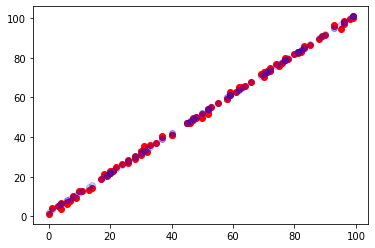

In [4]:
fig, ax = plt.subplots(1, 1)
ax.scatter(df['x'], df['y'], c='r', label='noisy output')
ax.scatter(df['x'], df['actual_output'], c='b', label='actual output',alpha=0.2)

## The Loss Function and Gradient

We assume that the loss function is the standard mean squared loss. 
$$
    \mathscr{L}(a, b) = \frac{1}{2M} \sum_{i = 1}^{M} (a x_i + b - y_i)^2
$$
The gradient $\nabla_{a, b} \mathscr{L}$ is then given by:
$$
    \nabla_{a, b} \mathscr{L} = 
        \left ( 
                \begin{array}{c}
                    \frac{1}{M} \sum_{i = 1}^{M} (a x_i + b - y_i) x_i \\
                    \frac{1}{M} \sum_{i = 1}^{M} (a x_i + b - y_i)
                \end{array}
        \right )
$$
Initially,let's look at vanilla gradient descent. It uses the entire data set to compute the gradient and then updates the parameters $a$ and $b$ as follows:
$$
\begin{align*}
    a_{t + 1} & = a_{t} - \eta \frac{1}{M} \sum_{i = 1}^{M} (a_{t} x_i + b_{t} - y_i) x_i \\
    b_{t + 1} & = b_{t} - \eta \frac{1}{M} \sum_{i = 1}^{M} (a_{t} x_i + b_{t} - y_i).
\end{align*}
$$
Here $\eta$ is the learning rate.

## Acclerated Gradient Descent



In [13]:
def loss(a: float, b: float, data_points: np.array):
    loss = 0.5 * np.mean(np.square(a * data_points[:, 0] + b - data_points[:, 1]))
    return loss

def nesterov_grad(a: float, 
                  b: float, 
                  v: np.array, 
                  data_points: np.array, 
                  gamma=0.9,
                  eta=1e-6):
    """
        Assume that data_points is an np.array with shape (-1, 1)
        v is an np.array with shape (2, 1)
    """
    m = len(data_points)
    if m == 0:
        return a, b
    
    assert data_points.shape[1] == 2
    assert v.shape == (2, 1)
    
    # calculate look-ahead
    a_la = a - gamma * v[0, 0]
    b_la = b - gamma * v[1, 0]
    
    # calculate gradients based on look-ahead
    grad_a = np.mean((a_la * data_points[:, 0] + b_la - data_points[:, 1]) * data_points[:, 0])
    grad_b = np.mean(a_la * data_points[:, 0] + b_la - data_points[:, 1])
    
    # calculate new momentum values
    v_a = gamma * v[0, 0] + eta * grad_a
    v_b = gamma * v[1, 0] + eta * grad_b
   
    a_new = a - v_a
    b_new = b - v_b
    
    # update v
    v[0, 0] = v_a
    v[1, 0] = v_b
    
    return a_new, b_new, v

def nesterov_grad_driver(a: float, b: float, 
                         data_points: np.array, 
                         num_iter=100):
    history = np.zeros(shape=(num_iter + 1, 3), dtype=np.float32)
    history[0, :] = [a, b, loss(a, b, data_points)]
    
    v = np.array([[0], [0]], dtype=np.float)
    eta =  1e-5
    
    for idx in range(num_iter):
        for l in range(len(data_points)):
            a, b, v = nesterov_grad(a, b, v, data_points[l, :].reshape(-1, 2), eta=eta)
        
        history[idx + 1, :] = [a, b, loss(a, b, data_points)]
    
    return history

In [14]:
hist1 = nesterov_grad_driver(a=0.5, b=-1, data_points=df[['x', 'y']].values, num_iter=10000)

In [15]:
hist1[-1]

array([1.0041728 , 1.8107424 , 0.49206802], dtype=float32)

## Plots

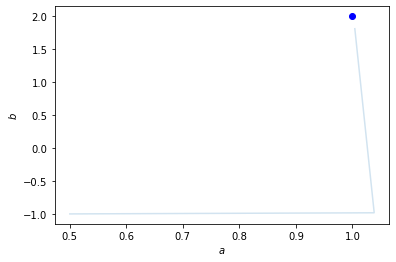

In [18]:
plt.plot([1], [2], 'ob')
plt.plot(hist1[:, 0], hist1[:, 1], alpha=0.2)
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
plt.show();